In [1]:
%reload_ext autoreload
%autoreload 2

import collections
import dataclasses
import enum
import functools
import io
import os
import pathlib
import re
import typing

import fastai
import fastai.vision
import IPython
import numpy as np
import pandas as pd
import PIL
import tqdm
import torch
import torch.nn.functional as F
import torch.utils.tensorboard
import torchvision
from matplotlib import pyplot as plt

import pipeline

path = pathlib.Path('/mnt/data1/smc_data/challenge2')
path2 = pathlib.Path('/home/jin/sandbox/smc_challenge2/images')

In [16]:
img_path = path2/'img11'

data = (
    fastai.vision.ImageList.from_folder(img_path, extensions='.png')
    .split_by_folder(train='train', valid='valid')
    .label_from_re(r'.*\.(\d{1,3})\.png$')
    .transform([[], []])
    .databunch(
        bs=500,
    )
)

learn = fastai.vision.cnn_learner(
    data,
    fastai.vision.models.resnet18,  # fastai passes pretrained=True
    metrics=[
        fastai.metrics.accuracy,
        fastai.metrics.top_k_accuracy,
    ],
)

learn2 = fastai.vision.cnn_learner(
    data,
    fastai.vision.models.resnet18,  # fastai passes pretrained=True
    metrics=[
        fastai.metrics.accuracy,
        fastai.metrics.top_k_accuracy,
    ],
)
learn2.unfreeze()

learn3 = fastai.vision.cnn_learner(
    data,
    fastai.vision.models.resnet34,  # fastai passes pretrained=True
    metrics=[
        fastai.metrics.accuracy,
        fastai.metrics.top_k_accuracy,
    ],
)
learn3.unfreeze()

In [13]:
for pg in learn.opt.opt.param_groups:
    print(len(pg['params']), pg['lr'])

0 slice(None, 0.003, None)
20 slice(None, 0.003, None)
0 slice(None, 0.003, None)
20 slice(None, 0.003, None)
2 slice(None, 0.003, None)
6 slice(None, 0.003, None)


In [15]:
for pg in learn2.opt.opt.param_groups:
    print(len(pg['params']), pg['lr'])

10 slice(None, 0.003, None)
20 slice(None, 0.003, None)
10 slice(None, 0.003, None)
20 slice(None, 0.003, None)
2 slice(None, 0.003, None)
6 slice(None, 0.003, None)


In [17]:
for pg in learn3.opt.opt.param_groups:
    print(len(pg['params']), pg['lr'])

16 slice(None, 0.003, None)
32 slice(None, 0.003, None)
20 slice(None, 0.003, None)
40 slice(None, 0.003, None)
2 slice(None, 0.003, None)
6 slice(None, 0.003, None)


In [2]:
img_path = path2/'img11'

data = (
    fastai.vision.ImageList.from_folder(img_path, extensions='.png')
    .split_by_folder(train='train', valid='valid')
    .label_from_re(r'.*\.(\d{1,3})\.png$')
    .transform([[], []])
    .databunch(
        bs=500,
    )
)

for _ in range(3):
    with torch.utils.tensorboard.SummaryWriter(comment='__img11_fastai_tmp_wd') as tbw:
        @dataclasses.dataclass
        class MyCallback(fastai.callback.Callback):
            learn: typing.Any

            def on_epoch_end(self, epoch, last_metrics, **kwargs):
                names = (
                    'Loss/valid/fastai',
                    'Accuracy/valid/fastai',
                    'Accuracy/valid_top_5/fastai',
                )
                assert len(last_metrics) == len(names)

                for name, val in zip(names, last_metrics):
                    tbw.add_scalar(name, val, epoch)

        learn = fastai.vision.cnn_learner(
            data,
            fastai.vision.models.resnet18,  # fastai passes pretrained=True
            metrics=[
                fastai.metrics.accuracy,
                fastai.metrics.top_k_accuracy,
            ],
            callback_fns=[MyCallback],
        )

        learn.fit_one_cycle(10, 2e-3, wd=0.01)
        
        learn.unfreeze()
        
        learn.fit_one_cycle(10, 1e-3, wd=0.01)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.621696,3.156859,0.179481,0.453366,00:48
1,2.626819,2.858997,0.232360,0.518573,00:48
2,2.127303,2.761771,0.270235,0.545742,00:47
3,1.852388,2.719260,0.292701,0.555637,00:48
4,1.640450,2.653157,0.309651,0.573155,00:48
5,1.455553,2.610607,0.325791,0.580454,00:48
6,1.308812,2.612769,0.349554,0.594809,00:48
7,1.201765,2.608010,0.354826,0.595134,00:48
8,1.122652,2.606626,0.360503,0.597161,00:48
9,1.094221,2.607162,0.361395,0.597648,00:48


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.064087,2.686949,0.350527,0.594079,01:03
1,1.043612,3.058603,0.297080,0.562044,01:02
2,0.698682,2.929678,0.364558,0.613625,01:02
3,0.404928,3.248407,0.373479,0.605110,01:02
4,0.244832,3.241570,0.399351,0.616383,01:02
5,0.143717,3.432838,0.422952,0.614761,01:02
6,0.094521,3.504128,0.448175,0.632441,01:02
7,0.065236,3.397700,0.461963,0.651014,01:02
8,0.045216,3.374265,0.469911,0.648094,01:02
9,0.033763,3.469223,0.469343,0.652717,01:02


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.607224,3.157668,0.192214,0.457908,00:48
1,2.606337,2.856024,0.247932,0.514436,00:48
2,2.121955,2.698741,0.281022,0.555556,00:48
3,1.859565,2.661242,0.304947,0.569100,00:48
4,1.640001,2.608747,0.319546,0.582968,00:48
5,1.461968,2.584419,0.337226,0.591079,00:48
6,1.308068,2.622968,0.351176,0.589375,00:48
7,1.188873,2.593885,0.361395,0.595296,00:48
8,1.137205,2.622176,0.364558,0.594079,00:48
9,1.108838,2.605835,0.361557,0.595539,00:48


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.060928,2.614197,0.349878,0.601946,01:02
1,1.049840,2.974785,0.285483,0.544526,01:02
2,0.714234,2.825806,0.362206,0.595215,01:02
3,0.397325,3.095306,0.394242,0.624331,01:02
4,0.246598,3.255173,0.391484,0.616383,01:02
5,0.142461,3.069091,0.433901,0.636091,01:02
6,0.094466,3.225919,0.452393,0.643715,01:02
7,0.065208,3.233205,0.457664,0.649311,01:02
8,0.049633,3.392122,0.458962,0.652960,01:02
9,0.036947,3.485261,0.459611,0.649635,01:02


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.604941,3.183689,0.187510,0.458394,00:48
1,2.592589,2.854240,0.238686,0.520519,00:48
2,2.114360,2.791667,0.270073,0.549148,00:48
3,1.844657,2.681212,0.297242,0.567234,00:48
4,1.639343,2.650315,0.314923,0.576480,00:48
5,1.459378,2.624608,0.330495,0.587997,00:48
6,1.326991,2.654064,0.349067,0.597891,00:48
7,1.203539,2.644008,0.353933,0.599838,00:48
8,1.133538,2.652872,0.358800,0.600162,00:48
9,1.096660,2.647113,0.358475,0.599351,00:48


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.062255,2.718552,0.346553,0.594647,01:02
1,1.050670,3.124358,0.299270,0.578345,01:02
2,0.712572,2.996369,0.332522,0.582806,01:02
3,0.395038,3.210595,0.368613,0.608029,01:02
4,0.251199,3.445119,0.379238,0.606569,01:02
5,0.153246,3.374262,0.442822,0.637794,01:02
6,0.096500,3.151326,0.452960,0.647607,01:02
7,0.066969,3.371972,0.461963,0.658962,01:02
8,0.046352,3.459576,0.467153,0.658881,01:02
9,0.035848,3.549564,0.469100,0.658800,01:02


In [4]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


AssertionError: 

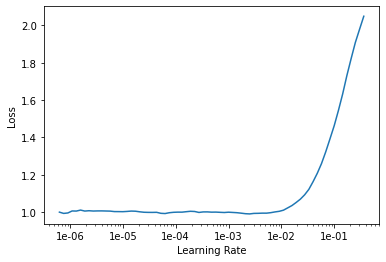

In [5]:
learn.recorder.plot()

In [ ]:
img_path = path2/'img9'

data = (
    fastai.vision.ImageList.from_folder(img_path, extensions='.png')
    .split_by_folder(train='train', valid='valid')
    .label_from_re(r'.*\.(\d{1,3})\.png$')
    .transform([[], []])
    .databunch(
        bs=500,
    )
)

for _ in range(3):
    with torch.utils.tensorboard.SummaryWriter(comment='__img9_fastai_tmp') as tbw:
        @dataclasses.dataclass
        class MyCallback(fastai.callback.Callback):
            learn: typing.Any

            def on_epoch_end(self, epoch, last_metrics, **kwargs):
                names = (
                    'Loss/valid/fastai',
                    'Accuracy/valid/fastai',
                    'Accuracy/valid_top_5/fastai',
                )
                assert len(last_metrics) == len(names)

                for name, val in zip(names, last_metrics):
                    tbw.add_scalar(name, val, epoch)

        learn = fastai.vision.cnn_learner(
            data,
            fastai.vision.models.resnet18,  # fastai passes pretrained=True
            metrics=[
                fastai.metrics.accuracy,
                fastai.metrics.top_k_accuracy,
            ],
            callback_fns=[MyCallback],
        )

        learn.fit_one_cycle(30, 1e-2)

In [24]:
img_path = path2/'img10'

data = (
    fastai.vision.ImageList.from_folder(img_path, extensions='.png')
    .split_by_folder(train='train', valid='valid')
    .label_from_re(r'.*\.(\d{1,3})\.png$')
    .transform([[], []])
    .databunch(
        bs=500,
    )
)

learn = fastai.vision.cnn_learner(
    data,
    fastai.vision.models.resnet18,
)

/home/jin/sandbox/smc_challenge2/smc_env/lib/python3.7/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
230, 92
  if getattr(ds, 'warn', False): warn(ds.warn)


epoch,train_loss,valid_loss,time
0,5.117718,#na#,00:01
1,5.102060,#na#,00:00
2,5.102552,#na#,00:00
3,5.104964,#na#,00:00
4,5.110117,#na#,00:00
5,5.069524,#na#,00:00
6,4.998834,#na#,00:00
7,4.794426,#na#,00:00
8,4.361339,#na#,00:00
9,3.801827,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


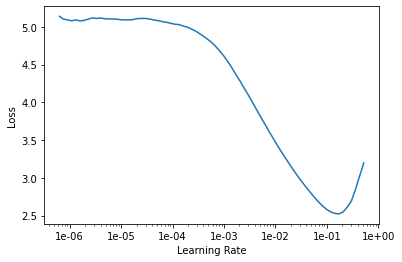

In [25]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
rates, losses = pipeline.find_lr(learn.data.train_dl, learn.model, learn.loss_func, learn.opt)

fig, ax = plt.subplots()

ax.plot(rates, losses)

ax.set_ylim(4, 6)
ax.set_xscale('log')
ax.grid()

In [96]:
with torch.utils.tensorboard.SummaryWriter(comment='__img9_0') as tbw:
    model = make_cnn_model(
        base_arch=fastai.vision.models.resnet18,
        num_classes=len(label_manager.raw_labels),
    ).cuda()
    opt = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
    ])

    learner = pipeline.Learner(
        model,
        F.cross_entropy,
        opt,
        tbw,
        train_loader,
        valid_loader,
    )

    learner.train_model(10, 1e-3)

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


In [71]:
fastai.core.defaults.lr

slice(None, 0.003, None)

In [38]:
img_path = path2/'img10'

tfms = [[],[]]

data = (
    fastai.vision.ImageList.from_folder(img_path, extensions='.png')
    .split_by_folder(train='train', valid='valid')
    .label_from_re(r'.*\.(\d{1,3})\.png$')
    .transform(tfms)
    .databunch(
        bs=500,
    )
)

flearn1 = fastai.vision.cnn_learner(
    data,
    fastai.vision.models.resnet18,  # fastai passes pretrained=True
)

flearn2 = fastai.vision.cnn_learner(
    data,
    fastai.vision.models.resnet18,  # fastai passes pretrained=True
)

sd1, sd2 = flearn1.model.state_dict(), flearn2.model.state_dict()

assert len(sd1) == len(sd2)

for k1, k2 in zip(sd1, sd2):
    assert k1 == k2
    v1, v2 = sd1[k1], sd2[k2]
    
    assert v1.shape == v2.shape
    if len(v1.shape) == 1:
        assert (v1 == v2).all()

/home/jin/sandbox/smc_challenge2/smc_env/lib/python3.7/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
230, 92
  if getattr(ds, 'warn', False): warn(ds.warn)


In [6]:
flearn1 = fastai.vision.cnn_learner(
    fastai.vision.ImageList.from_folder(path2/'img10', extensions='.png')
        .split_by_folder(train='train', valid='valid')
        .label_from_re(r'.*\.(\d{1,3})\.png$')
        .transform([[],[]])
        .databunch(
            bs=200,
        ),
    fastai.vision.models.resnet18,  # fastai passes pretrained=True
    init=torch.nn.init.kaiming_normal_,
)
sd1 = flearn1.model.state_dict()

model = pipeline.make_cnn_model(
    base_arch=fastai.vision.models.resnet18,
    num_classes=len(label_manager.raw_labels),
).cuda()
sd3 = model.state_dict()

for k1, k2 in zip(sd1, sd3):
    assert k1 == k2
    v1, v2 = sd1[k1], sd3[k2]

    assert v1.shape == v2.shape
    if len(v1.shape) == 1:
        assert (v1 == v2).all()
        if (v1 != v2).any():
            print(k1)
    
    if not k1.startswith('1.'): continue

    if len(v1.shape) > 0:
        fns = ['mean', 'std', 'sum']
        
        ds = []
        for fn in fns:
            a = getattr(v1, fn)().item()
            b = getattr(v2, fn)().item()
            ds.append(round(a - b, 4))
            
        # dmean = v1.mean().item() - v2.mean().item()
        # dstd = v1.std().item() - v2.std().item()
        print(k1, ds, round(v1.sum().item()), round(v2.sum().item()))

/home/jin/sandbox/smc_challenge2/smc_env/lib/python3.7/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
230, 92
  if getattr(ds, 'warn', False): warn(ds.warn)


1.2.weight [0.0, 0.0, 0.0] 1024 1024
1.2.bias [0.0, 0.0, 0.0] 0 0
1.2.running_mean [0.0, 0.0, 0.0] 0 0
1.2.running_var [0.0, 0.0, 0.0] 1024 1024
1.4.weight [0.0002, 0.0, 112.819] 65 -48
1.4.bias [0.0, 0.0, 0.0] 0 0
1.6.weight [0.0, 0.0, 0.0] 512 512
1.6.bias [0.0, 0.0, 0.0] 0 0
1.6.running_mean [0.0, 0.0, 0.0] 0 0
1.6.running_var [0.0, 0.0, 0.0] 512 512
1.8.weight [-0.0002, 0.0005, -3.2888] -12 -8
1.8.bias [0.0, 0.0, 0.0] 0 0


In [8]:
flearn1.train_bn

True

In [47]:
model[1] = flearn1.model[1]

In [82]:
len(label_manager.raw_labels)

29

In [70]:
len(flearn.model.state_dict())

134

In [63]:
flearn.model == flearn2.model

False

In [66]:
len(list(flearn.model.parameters())), len(list(flearn2.model.parameters()))

(68, 68)

In [ ]:
rates, losses = pipeline.find_lr(learn.data.train_dl, learn.model, learn.loss_func, learn.opt)

fig, ax = plt.subplots()

ax.plot(rates, losses)

ax.set_ylim(4, 6)
ax.set_xscale('log')
ax.grid()

In [5]:
img_path = path2/'img10'

label_manager = pipeline.LabelManager()

train_set = pipeline.CbedDataset(img_path/'train', label_manager)

label_manager.freeze()

valid_set = pipeline.CbedDataset(img_path/'valid', label_manager)

print(len(train_set.filenames), len(train_set.labels))
print(len(valid_set.filenames), len(valid_set.labels))

batch_size = 200

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
)
valid_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
)

1323 1323
90 90


In [25]:
a, b = 0, 0

for p in flearn1.model[0].parameters():
    if p.requires_grad:
        a += 1
    else:
        b += 1

a, b

(40, 20)

In [15]:
a = 0

for p in flearn1.model[0].parameters():
    if p.requires_grad:
        print(a, p.shape, isinstance(p)
        a += 1

0 torch.Size([64]) False
1 torch.Size([64]) False
2 torch.Size([64]) False
3 torch.Size([64]) False
4 torch.Size([64]) False
5 torch.Size([64]) False
6 torch.Size([64]) False
7 torch.Size([64]) False
8 torch.Size([64]) False
9 torch.Size([64]) False
10 torch.Size([128]) False
11 torch.Size([128]) False
12 torch.Size([128]) False
13 torch.Size([128]) False
14 torch.Size([128]) False
15 torch.Size([128]) False
16 torch.Size([128]) False
17 torch.Size([128]) False
18 torch.Size([128]) False
19 torch.Size([128]) False
20 torch.Size([256]) False
21 torch.Size([256]) False
22 torch.Size([256]) False
23 torch.Size([256]) False
24 torch.Size([256]) False
25 torch.Size([256]) False
26 torch.Size([256]) False
27 torch.Size([256]) False
28 torch.Size([256]) False
29 torch.Size([256]) False
30 torch.Size([512]) False
31 torch.Size([512]) False
32 torch.Size([512]) False
33 torch.Size([512]) False
34 torch.Size([512]) False
35 torch.Size([512]) False
36 torch.Size([512]) False
37 torch.Size([512]) 

In [24]:
a = 0

stack = [flearn1.model[0]]

while stack:
    m = stack.pop(0)
    stack.extend(m.children())
    
    if isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d, torch.nn.BatchNorm3d)):
        p_shapes = [p.shape for p in m.parameters()]
        print(a, len(p_shapes), p_shapes)
    else:
        

0 2 [torch.Size([64]), torch.Size([64])]
1 2 [torch.Size([64]), torch.Size([64])]
2 2 [torch.Size([64]), torch.Size([64])]
3 2 [torch.Size([64]), torch.Size([64])]
4 2 [torch.Size([64]), torch.Size([64])]
5 2 [torch.Size([128]), torch.Size([128])]
6 2 [torch.Size([128]), torch.Size([128])]
7 2 [torch.Size([128]), torch.Size([128])]
8 2 [torch.Size([128]), torch.Size([128])]
9 2 [torch.Size([256]), torch.Size([256])]
10 2 [torch.Size([256]), torch.Size([256])]
11 2 [torch.Size([256]), torch.Size([256])]
12 2 [torch.Size([256]), torch.Size([256])]
13 2 [torch.Size([512]), torch.Size([512])]
14 2 [torch.Size([512]), torch.Size([512])]
15 2 [torch.Size([512]), torch.Size([512])]
16 2 [torch.Size([512]), torch.Size([512])]
17 2 [torch.Size([128]), torch.Size([128])]
18 2 [torch.Size([256]), torch.Size([256])]
19 2 [torch.Size([512]), torch.Size([512])]


In [13]:
type(p)

torch.nn.parameter.Parameter

In [20]:
a = 0

for p in learn.model[0].parameters():
    if not p.requires_grad:
        print(a, p.shape)
        a += 1

0 torch.Size([64, 3, 7, 7])
1 torch.Size([64, 64, 3, 3])
2 torch.Size([64, 64, 3, 3])
3 torch.Size([64, 64, 3, 3])
4 torch.Size([64, 64, 3, 3])
5 torch.Size([128, 64, 3, 3])
6 torch.Size([128, 128, 3, 3])
7 torch.Size([128, 64, 1, 1])
8 torch.Size([128, 128, 3, 3])
9 torch.Size([128, 128, 3, 3])
10 torch.Size([256, 128, 3, 3])
11 torch.Size([256, 256, 3, 3])
12 torch.Size([256, 128, 1, 1])
13 torch.Size([256, 256, 3, 3])
14 torch.Size([256, 256, 3, 3])
15 torch.Size([512, 256, 3, 3])
16 torch.Size([512, 512, 3, 3])
17 torch.Size([512, 256, 1, 1])
18 torch.Size([512, 512, 3, 3])
19 torch.Size([512, 512, 3, 3])


In [ ]:
p.ran